In [1]:
# nHP = 3, nSN = 12

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [3]:
model = gp.Model("DroneDataCollection")

In [4]:

nHP = 3    # max number of hover points
nSN = 12   # numver of sensing nodes
M   = 5    # 

I = range(nHP)   # hover points decision variable
J = range(nSN)   # sensing nodes decision variable

snp = np.random.rand(nSN, 2) * 1000

In [5]:
y  = model.addVars(I, J, vtype=GRB.BINARY, name="y")                    
h  = model.addVars(nHP, 2, vtype=GRB.CONTINUOUS, name="h")              
d1 = model.addVars(nHP, nSN, vtype=GRB.CONTINUOUS, name="Distance")     
bh = model.addVars(nHP, vtype=GRB.BINARY, name="bh")                    

d2 = model.addVars(nHP, nHP, vtype=GRB.CONTINUOUS, name="Distance")     
tx = model.addVars(nHP, nHP, vtype=GRB.BINARY, name="tx")
u  = model.addVars(nHP, vtype=GRB.CONTINUOUS)

In [6]:
# distance between hover point and sensing node
for i in range(nHP):
    for j in range(nSN):
        model.addConstr(d1[i, j] >=   h[i, 0] - snp[j, 0] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 0] - snp[j, 0])- 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >=   h[i, 1] - snp[j, 1] - 1000 * (1-y[i,j]))
        model.addConstr(d1[i, j] >= -(h[i, 1] - snp[j, 1])- 1000 * (1-y[i,j]))

# distance between hover points
for i in range(nHP):
    for j in range(nHP):
        if (i == j):
            model.addConstr(d2[i, j] >= 1000*1000)
        else:
            model.addConstr(d2[i, j] >=   h[i, 0] - h[j, 0] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 0] - h[j, 0])- 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >=   h[i, 1] - h[j, 1] - 2000 * (2-bh[i]-bh[j]))
            model.addConstr(d2[i, j] >= -(h[i, 1] - h[j, 1])- 2000 * (2-bh[i]-bh[j]))


In [7]:
model.addConstrs(h[i, 0] >=    0 for i in I)
model.addConstrs(h[i, 0] <= 1000 for i in I)
model.addConstrs(h[i, 1] >=    0 for i in I)
model.addConstrs(h[i, 1] <= 1000 for i in I)
pass

In [8]:
model.addConstrs((gp.quicksum(y[i, j] for i in I) == 1 for j in J), "SensingNodeCoverage")
model.addConstrs((gp.quicksum(y[i, j] for j in J) <= M * bh[i] for i in I), "MaxCoveredSensorsPerHoveringPoint")
pass

In [9]:
# TSP
model.addConstrs((gp.quicksum(tx[i, j] for i in I) == bh[j] for j in I), "TSPConstr1")
model.addConstrs((gp.quicksum(tx[i, j] for j in I) == bh[i] for i in I), "TSPConstr2")
tHP = gp.quicksum(bh[i] for i in I)
for i in range(1, nHP):  
    for j in range(1, nHP): 
        if(i!=j):
            model.addConstr((u[i]-u[j]+tHP*tx[i,j])<=tHP-1)
pass

In [10]:
x1 = gp.quicksum( y[i, j]*d1[i, j] for i in I for j in J)
x2 = gp.quicksum(tx[i, j]*d2[i, j] for i in I for j in I)
model.setObjective(x1 + x2, GRB.MINIMIZE)

In [11]:
data = {'objbnds': [], 'objbsts': [], 'objbstsols': [], 'times': [], 'times_mipsol': []}
def collect_data(model, where):
    if where == gp.GRB.Callback.MIPNODE:
        objbnd = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBND)
        objbst = model.cbGet(gp.GRB.Callback.MIPNODE_OBJBST)
        
        data['objbnds'].append(objbnd)
        data['objbsts'].append(objbst)
        data['times'].append(model.cbGet(gp.GRB.Callback.RUNTIME))
    
    elif where == gp.GRB.Callback.MIPSOL:
        objbstsol = model.cbGet(gp.GRB.Callback.MIPSOL_OBJ)
        data['objbstsols'].append(objbstsol)
        data['times_mipsol'].append(model.cbGet(gp.GRB.Callback.RUNTIME))

In [12]:
model.params.TimeLimit = 3600
model.optimize(collect_data)

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: AMD Ryzen 5 5600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 204 rows, 102 columns and 666 nonzeros
Model fingerprint: 0x2f1bea1f
Model has 45 quadratic objective terms
Model has 2 quadratic constraints
Variable types: 54 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
  QRHS range       [1e+00, 1e+00]
Presolve removed 11 rows and 5 columns
Presolve time: 0.00s
Presolved: 277 rows, 223 columns, 875 nonzeros
Presolved model has 84 SOS constraint(s)
Variable types: 132 continuous, 91 integer (90 binary)

Root

In [13]:
num_vars = model.NumVars
print(f"Number of variables: {num_vars}")

num_constrs = model.NumConstrs
print(f"Number of constraints: {num_constrs}")

m_optimal = model.status == GRB.OPTIMAL
print(f"Is optimal: {m_optimal}")

Number of variables: 102
Number of constraints: 204
Is optimal: True


In [14]:
res_h = np.zeros([nHP, 2])
for i in range(nHP):
    res_h[i, 0] = h[i, 0].X
    res_h[i, 1] = h[i, 1].X
res_bh = np.array([bh[i].X for i in I])

In [15]:
# tsp_dict
tsp_dict = { (i, j): 0 for i in I for j in I }
for i in I:
    for j in I:
        value = model.getVarByName(f"tx[{i},{j}]").x
        tsp_dict[(i, j)] = value

# tans_dict
tans_dict = { (i, j): 0 for i in I for j in J }
for i in I:
    for j in J:
        value = model.getVarByName(f"y[{i},{j}]").x
        tans_dict[(i, j)] = value


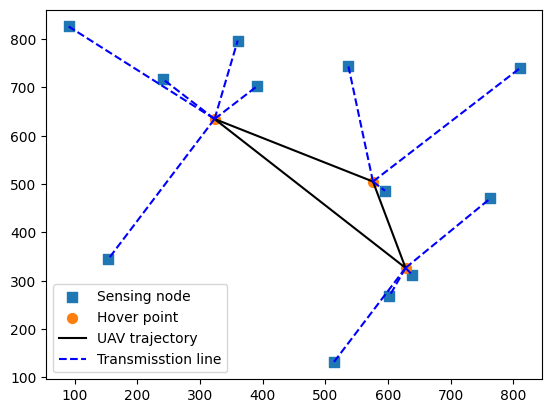

In [16]:
import matplotlib.pylab as plt
res_h2 = res_h[res_bh.astype(bool)]
plt.scatter(snp[:, 0], snp[:, 1], marker='s', s=50, label='Sensing node')
plt.scatter(res_h2[:, 0], res_h2[:, 1], marker='o', s=50, label='Hover point')

route = [key for key,value in tsp_dict.items() if value == 1]
for r in route:
    plt.plot([res_h[r[0],0], res_h[r[1],0]], [res_h[r[0],1], res_h[r[1],1]], 'k-')
line, = plt.plot([], [], 'k-', label="UAV trajectory")

tansr = [key for key,value in tans_dict.items() if value == 1]
for r in tansr:
    plt.plot([res_h[r[0],0], snp[r[1],0]], [res_h[r[0],1], snp[r[1],1]], 'b--')
line, = plt.plot([], [], 'b--', label='Transmisstion line')
plt.legend()
plt.show()

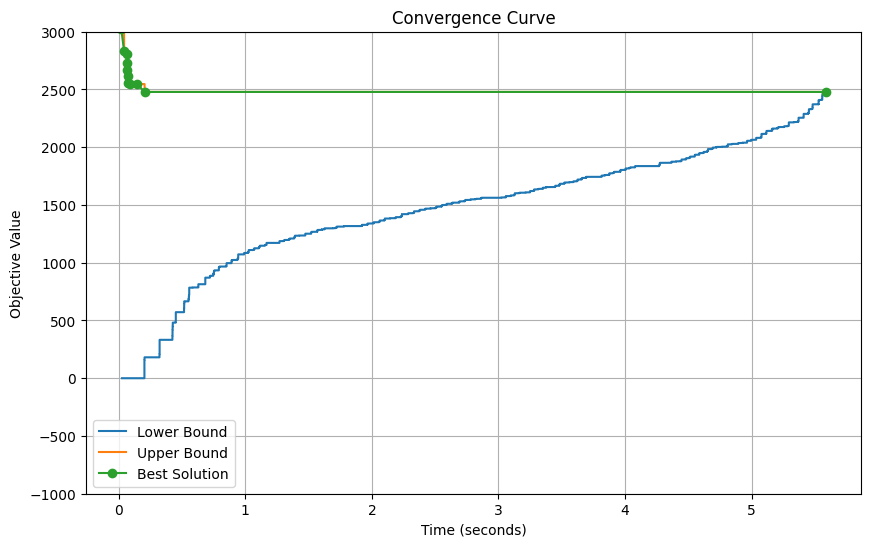

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(data['times'], data['objbnds'], label='Lower Bound')

plt.plot(data['times'], data['objbsts'], label='Upper Bound')

plt.plot(data['times_mipsol'], data['objbstsols'], label='Best Solution', marker='o')

plt.xlabel('Time (seconds)')
plt.ylabel('Objective Value')
plt.title('Convergence Curve')
plt.legend()
plt.grid(True)
plt.ylim([-1000, 3000])
plt.show()

In [18]:
snp

array([[763.62551275, 470.39354437],
       [241.06835411, 716.8629588 ],
       [513.28972782, 130.82816837],
       [360.24347303, 796.78245605],
       [602.29369187, 268.02780052],
       [391.38031215, 702.60478569],
       [153.80475982, 344.82277138],
       [ 90.44777742, 825.95153189],
       [537.05231323, 743.31015698],
       [810.10710403, 739.07054633],
       [595.21839772, 486.05229777],
       [639.10315049, 311.82581597]])

In [19]:

count = 0

for i in I:
    row = [round(tans_dict[(i, j)]) for j in J]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0] 5
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0] 3
[1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1] 4
12


In [20]:

count = 0

for i in I:
    row = [round(tsp_dict[(i, j)]) for j in I]
    count += sum(row)
    print(row, sum(row))
print(count)

[0, 1, 0] 1
[0, 0, 1] 1
[1, 0, 0] 1
3


In [21]:

res_h

array([[323.35341969, 634.57789323],
       [576.1536266 , 505.1170689 ],
       [628.1402659 , 326.48437558]])

In [22]:

res_d = np.zeros([nHP, nSN])
for i in range(nHP):
    for j in range(nSN):
        res_d[i, j] = d1[i, j].X
res_d

array([[  0.        ,  82.28506559,   0.        , 162.20456282,
          0.        ,  68.02689247, 289.75512186, 232.90564228,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        238.19308809, 233.95347744,  19.06477113,   0.        ],
       [143.9091688 ,   0.        , 195.65620722,   0.        ,
         58.45657506,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,  14.65855962]])

In [23]:

res_d = np.zeros([nHP, nHP])
for i in range(nHP):
    for j in range(nHP):
        res_d[i, j] = d2[i, j].X
res_d

array([[1.00000000e+06, 2.52800207e+02, 3.09000000e+02],
       [2.53000000e+02, 1.00000000e+06, 1.78632693e+02],
       [3.08093518e+02, 1.79000000e+02, 1.00000000e+06]])

In [24]:
res_bh

array([1., 1., 1.])